In [2]:
#import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import warnings
import pprint
import time
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Modeling

Jupyter Notebook only focused on performance of the models. The notebook is divided into 4 parts:

- Feature engineering & selection
- Model selection
- Model evaluation
- Model comparison

## Feature Engineering & Selection


In [63]:
# import data

df = pd.read_csv('AB_NYC_2019.csv')

In [15]:
df.shape

(48895, 16)

In [19]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [37]:
def corr_plot(df):
    '''
    Plot correlation matrix

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe to plot

    Returns
    -------
    plot of correlation matrix
    
    '''

    corr = df.corr()
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax, mask= np.triu(corr, k=1))
    plt.show()


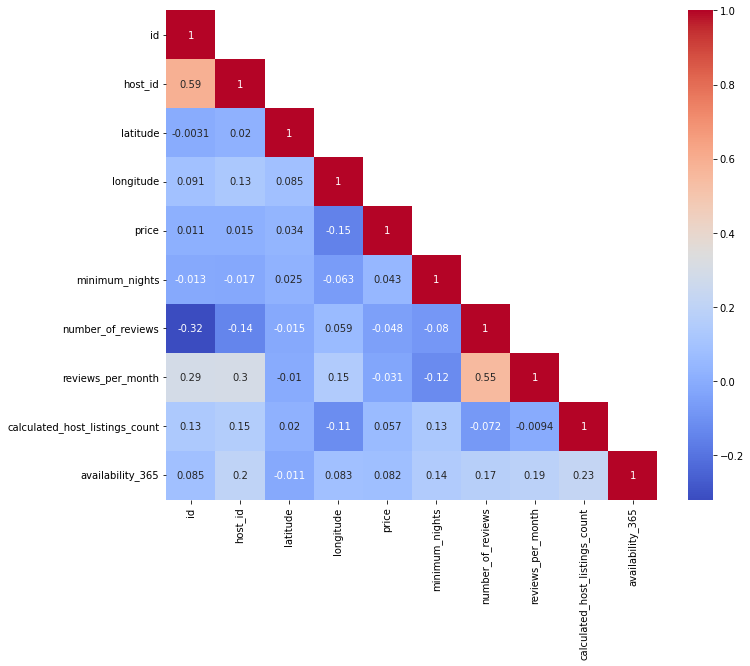

In [20]:
corr_plot(df)

In [52]:
# print boxplot for each column to check for outliers

def boxplot(df):
    '''
    Plot boxplot for each column

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe to plot

    Returns
    -------
    plot of boxplot for each column
    
    '''
    #get all numeric columns:
    num_cols = df.select_dtypes(include=np.number).columns
    #get all categorical columns:
    cat_cols = df.select_dtypes(include='object').columns

    #plot boxplot for each numeric column
    for col in num_cols:
        plt.figure(figsize=(10,5))
        sns.boxplot(df[col])
        plt.title(col)
        plt.show()

    #plot boxplot for each categorical column
    for col in cat_cols:
        plt.figure(figsize=(10,5))
        sns.boxplot(x= df[col], y= df['price'])
        plt.title(col)
        plt.show()
        


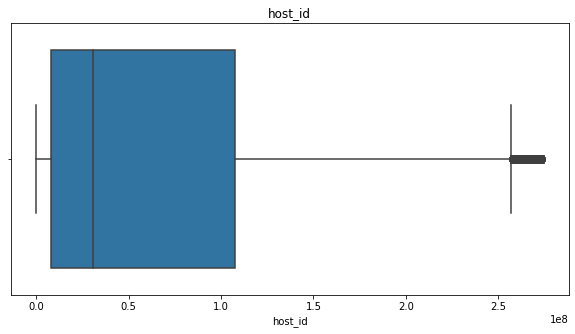

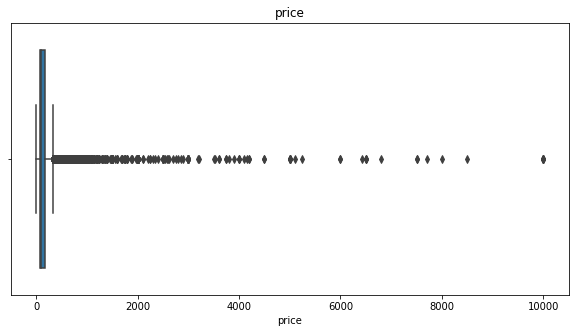

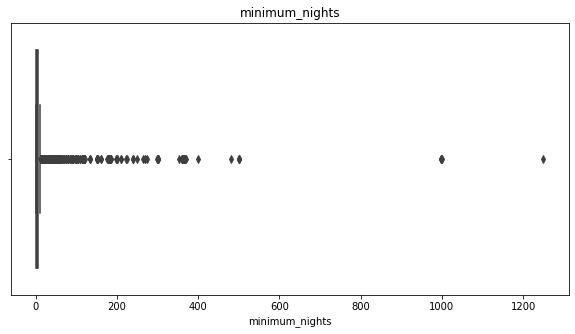

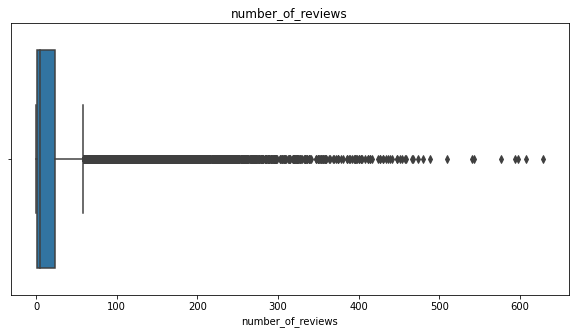

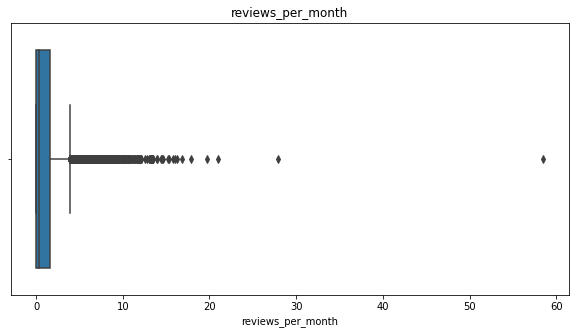

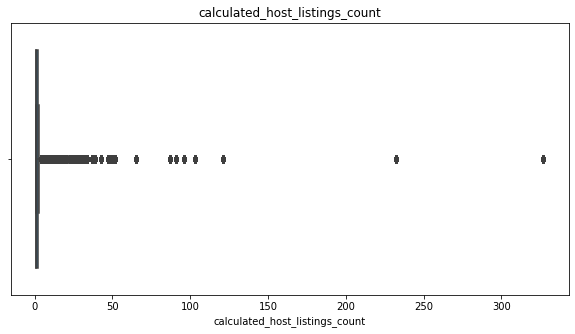

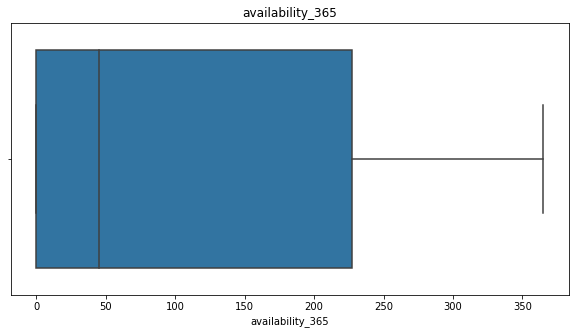

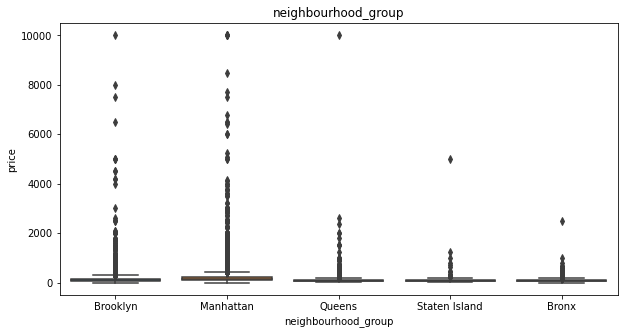

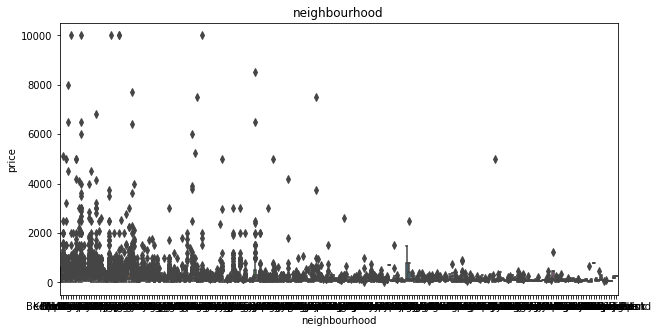

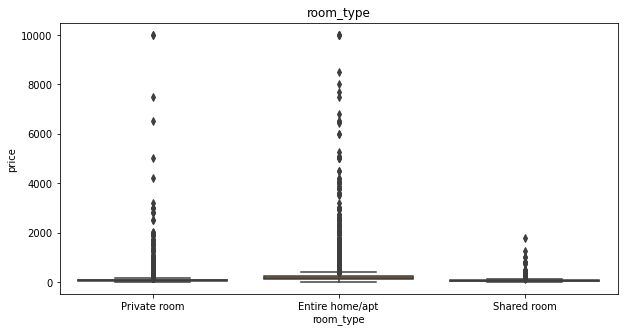

In [53]:
boxplot(df)

In [64]:
def feature_engineering(df, outliers:bool = False,outliers_method:str =None, scaling:bool = False, scaling_method:str = None):


    cols_to_drop = ['name', 'host_name', 'last_review', 'id', 'longitude', 'latitude'] # columns to drop, first model run with host_id

    df.drop(cols_to_drop, axis=1, inplace=True)

    # replace NaN values by 0 in reviews_per_month column
    df['reviews_per_month'].fillna(0, inplace=True)
    # one hot encoding of neighbourhood_group column
    df = pd.get_dummies(df, columns=['neighbourhood_group', 'room_type'], drop_first=True)

    # drop outliers
    # get all numerical columns
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # #remove outliers with zscore

    # if outliers:
    #     if outliers_method == 'zscore':
    #         z = np.abs(stats.zscore(df[num_cols]))
    #         df = df[(z < 3).all(axis=1)]
    #     elif outliers_method == 'iqr':
    #         q1 = df[num_cols].quantile(0.25)
    #         q3 = df[num_cols].quantile(0.75)
    #         iqr = q3 - q1
    #         df = df[~((df[num_cols] < (q1 - 1.5 * iqr)) |(df[num_cols] > (q3 + 1.5 * iqr))).any(axis=1)]
    #     else:
    #         print('Invalid outliers method')
    #         return

    # split data into train and test sets

    X = df.drop('price', axis=1)
    y = df['price']

    cols = X.columns

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # target encode neighbourhood and host_id columns

    # neighbourhood
    import category_encoders as ce
    encoder = ce.TargetEncoder(cols=['neighbourhood'])
    X_train = encoder.fit_transform(X_train, y_train)
    X_test = encoder.transform(X_test)

    # host_id
    encoder = ce.TargetEncoder(cols=['host_id'])
    X_train = encoder.fit_transform(X_train, y_train)
    X_test = encoder.transform(X_test)

    #get size of train and test sets before dropping outliers

    x_train_before = X_train.shape[0]
    y_train_before = y_train.shape[0]
    x_test_before = X_test.shape[0]
    y_test_before = y_test.shape[0]

    # drop outliers

    if outliers:
        if outliers_method == 'zscore':
            # concat both train sets
            df_train = pd.concat([X_train, y_train], axis=1)
            # get zscore
            z = np.abs(stats.zscore(df_train))
            # drop outliers
            df_train = df_train[(z < 3.5).all(axis=1)]

            # split data into X and y
            X_train = df_train.drop('price', axis=1)
            y_train = df_train['price']

            # concat both test sets
            df_test = pd.concat([X_test, y_test], axis=1)
            # get zscore
            z = np.abs(stats.zscore(df_test))
            # drop outliers
            df_test = df_test[(z < 3.5).all(axis=1)]

            # split data into X and y
            X_test = df_test.drop('price', axis=1)
            y_test = df_test['price']
        elif outliers_method == 'iqr':
            q1 = X_train.quantile(0.25)
            q3 = X_train.quantile(0.75)
            iqr = q3 - q1
            X_train = X_train[~((X_train < (q1 - 1.5 * iqr)) |(X_train > (q3 + 1.5 * iqr))).any(axis=1)]
            y_train = y_train[~((X_train < (q1 - 1.5 * iqr)) |(X_train > (q3 + 1.5 * iqr))).any(axis=1)]

            X_test = X_test[~((X_train < (q1 - 1.5 * iqr)) |(X_train > (q3 + 1.5 * iqr))).any(axis=1)]
            y_test = y_test[~((X_train < (q1 - 1.5 * iqr)) |(X_train > (q3 + 1.5 * iqr))).any(axis=1)]
        else:
            print('Invalid outliers method')
            return

    
    #get size of train and test sets after dropping outliers

    x_train_after = X_train.shape[0]
    y_train_after = y_train.shape[0]
    x_test_after = X_test.shape[0]
    y_test_after = y_test.shape[0]

    # print how many rows were dropped

    print(f'Differnece between train sets before and after dropping outliers: {x_train_before - x_train_after}')
    print(f'Differnece between test sets before and after dropping outliers: {x_test_before - x_test_after}')

    # print ratio of how many rows were dropped compared to the total number of rows

    print(f'Ratio of train sets before and after dropping outliers: {np.round((x_train_before - x_train_after) / x_train_before, 4) * 100} %')
    print(f'Ratio of test sets before and after dropping outliers: {np.round((x_test_before - x_test_after) / x_test_before, 4) * 100} %')
   
    
    # scale the data 

    if scaling:
        if scaling_method == 'standard':
            scaler = StandardScaler()
        elif scaling_method == 'minmax':
            scaler = MinMaxScaler()
        elif scaling_method == 'robust':
            scaler = RobustScaler()
        else:
            print('Invalid scaling method')
            return

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, cols

In [65]:
X_train, X_test, y_train, y_test, colname = feature_engineering(df, outliers=True, outliers_method='zscore', scaling=True, scaling_method='standard')

Differnece between train sets before and after dropping outliers: 3431
Differnece between test sets before and after dropping outliers: 905
Ratio of train sets before and after dropping outliers: 8.77 %
Ratio of test sets before and after dropping outliers: 9.25 %


In [66]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35685, 13), (8874, 13), (35685,), (8874,))

In [67]:
from sklearn.feature_selection import VarianceThreshold

from sklearn.feature_selection import SelectKBest, f_regression, RFE

def select_features(X_train, y_train, X_test, method:str=None, VT_threshold=0.1, KBest_k=10):


    if method == 'variance':
        # create an instance of VarianceThreshold with a threshold of 0.1
        selector = VarianceThreshold(threshold=VT_threshold)

        # fit the selector to the training data
        selector.fit(X_train)

        # transform the training and test data using the selector
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)

        # get the columns that were selected
        selected_columns = colname[selector.get_support()]

        # print the columns that were not selected

        print('Columns with low variance: ', set(colname) - set(selected_columns))
        
        return X_train, X_test, selected_columns

    elif method == 'univariate':
        # create an instance of SelectKBest with the desired parameters
        selector = SelectKBest(f_regression, k=10)

        # fit the selector to the training data
        selector.fit(X_train, y_train)

        # transform the training and test data using the selector
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)

        # get the columns that were selected
        selected_columns = colname[selector.get_support()]

        # print the columns that were not selected

        print('Columns with low variance: ', set(colname) - set(selected_columns))
        
        return X_train, X_test, selected_columns

    elif method == 'recursive':
        # create an instance of SelectKBest with the desired parameters
        selector = RFE(estimator=LinearRegression(), n_features_to_select=10)

        # fit the selector to the training data
        selector.fit(X_train, y_train)

        # transform the training and test data using the selector
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)

        # get the columns that were selected
        selected_columns = colname[selector.get_support()]

        # print the columns that were not selected

        print('Columns with low variance: ', set(colname) - set(selected_columns))
        
        return X_train, X_test, selected_columns

    else:
        print('Invalid method')

In [68]:
X_train, X_test, selected_columns = select_features(X_train, y_train, X_test, method='variance')

Columns with low variance:  {'room_type_Shared room', 'neighbourhood_group_Staten Island'}


In [69]:
# choix des models
def preprocessing(X_train, X_test, y_train, y_test):  
    models = {'Decision Tree Regressor' : DecisionTreeRegressor(random_state=42),
          'Bagging Regressor' : BaggingRegressor(random_state=42, base_estimator=DecisionTreeRegressor(random_state=42)),
          'AdaBoost Regressor' : AdaBoostRegressor(random_state=42, base_estimator=DecisionTreeRegressor(random_state=42)),
          'RandomForestRegressor' :RandomForestRegressor(random_state=42, n_jobs=-1), 
          'ExtraTreesRegressor' : ExtraTreesRegressor(random_state=42, n_jobs=-1),
          'GradientBoostingRegressor' : GradientBoostingRegressor(random_state=42),
          'XGBoostRegressor' : xgb.XGBRegressor( objective ='reg:squarederror', n_jobs=-1, tree_method='gpu_hist', gpu_id=0, random_state=42),
          'LightGBMRegressor' : LGBMRegressor(random_state=42, n_jobs=-1),
          'CatBoostRegressor' : CatBoostRegressor(random_state=42, silent=True, task_type='GPU', devices='0:1')}

    results = []
    for model_name, model in models.items():
        start = time.time()
        # cross-validation
        cross_val = cross_val_score(model, X_train, y_train, cv=5)
        # model fitting and prediction
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # calculating metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        # saving results in a list
        results.append([model_name, cross_val.mean(), mse, rmse, mae, r2])
        end = time.time()
        print(f'{model_name} done !')
        print(f'Time taken: {end-start:.2f} seconds')
        print('--------------------------------------')

    # creating a DataFrame with the results
    df = pd.DataFrame(results, columns=['Model', 'Cross-Val Score', 'MSE', 'RMSE', 'MAE', 'R2'])
    # sorting by best R2 and RMSE scores
    df = df.sort_values(by=['R2', 'RMSE'], ascending=[False, True])
    # resetting the index
    df.reset_index(drop=True, inplace=True)
    return df

In [70]:
df_models = preprocessing(X_train, X_test, y_train, y_test)

Decision Tree Regressor done !
Time taken: 0.92 seconds
--------------------------------------
Bagging Regressor done !
Time taken: 7.92 seconds
--------------------------------------
AdaBoost Regressor done !
Time taken: 13.41 seconds
--------------------------------------
RandomForestRegressor done !
Time taken: 11.50 seconds
--------------------------------------
ExtraTreesRegressor done !
Time taken: 7.34 seconds
--------------------------------------
GradientBoostingRegressor done !
Time taken: 12.88 seconds
--------------------------------------
XGBoostRegressor done !
Time taken: 2.13 seconds
--------------------------------------
LightGBMRegressor done !
Time taken: 0.97 seconds
--------------------------------------
CatBoostRegressor done !
Time taken: 71.08 seconds
--------------------------------------


In [62]:
# run with outliers before split a 3 of z score

df_models

,Model,Cross-Val Score,MSE,RMSE,MAE,R2
0,LightGBMRegressor,0.533647,6127.312891,78.277154,46.593508,0.469632
1,CatBoostRegressor,0.532390,6146.550206,78.399938,46.601457,0.467967
2,XGBoostRegressor,0.508138,6258.826514,79.112746,47.205453,0.458249
3,GradientBoostingRegressor,0.517415,6278.812094,79.238956,47.369129,0.456519
4,RandomForestRegressor,0.480165,6637.473894,81.470693,48.681956,0.425474
5,ExtraTreesRegressor,0.439226,7061.502177,84.032745,49.945992,0.388771
6,Bagging Regressor,0.441996,7080.116394,84.143428,50.209205,0.387159
7,AdaBoost Regressor,0.381600,7859.497438,88.653807,51.190560,0.319698
8,Decision Tree Regressor,0.059061,11562.789282,107.530411,62.650639,-0.000852


In [71]:
# run with outliers after split at 3.5 of z score

df_models

,Model,Cross-Val Score,MSE,RMSE,MAE,R2
0,LightGBMRegressor,0.465053,5548.244812,74.486541,45.161587,0.453645
1,CatBoostRegressor,0.463992,5571.179739,74.640336,45.559122,0.451387
2,GradientBoostingRegressor,0.453240,5653.068609,75.186891,45.837079,0.443323
3,XGBoostRegressor,0.436112,5833.101061,76.374741,46.024653,0.425594
4,RandomForestRegressor,0.404534,6238.383747,78.983440,47.798327,0.385685
5,ExtraTreesRegressor,0.364122,6683.589473,81.753223,48.906309,0.341844
6,Bagging Regressor,0.361397,6875.581896,82.919129,49.808152,0.322938
7,AdaBoost Regressor,0.282875,7542.482184,86.847465,49.309946,0.257266
8,Decision Tree Regressor,-0.057369,10883.240568,104.322771,59.606538,-0.071711


Let's focus on the model tuning on our 3models :
- Decision Tree Classifier
- Random Forest Classifier
- XGBoost



In [7]:
def DT_tuning(X_train, X_test, y_train, y_test):
    # define the grid of values for max_depth and min_samples_leaf
    param_grid = {'max_depth': [3, 5, 7],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 2, 3]}

    # instantiate a DecisionTreeRegressor
    dt = DecisionTreeRegressor(random_state=42)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    # instantiate the GridSearchCV object and run the search
    dt_cv = GridSearchCV(dt, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    dt_cv.fit(X_train, y_train)
    # print the optimal parameters and best score
    print("Tuned Decision Tree Parameters: {}".format(dt_cv.best_params_)) 
    print("Best score is {}".format(dt_cv.best_score_))
    print("Best estimator is {}".format(dt_cv.best_estimator_))

    print('-------------------------------------------------')
    # instantiate a DecisionTreeRegressor with the optimal parameters
    dt_tuned = DecisionTreeRegressor(random_state=42, **dt_cv.best_params_)

    # fit dt_tuned to the training set
    dt_tuned.fit(X_train, y_train)

    # predict test set labels
    y_pred = dt_tuned.predict(X_test)

    # compute mse_dt
    mse_dt = mean_squared_error(y_test, y_pred)

    # compute rmse_dt
    rmse_dt = np.sqrt(mse_dt)

    # compute mae_dt
    mae_dt = mean_absolute_error(y_test, y_pred)

    # compute r2_dt

    r2_dt = r2_score(y_test, y_pred)

    df_results = pd.DataFrame({'Model': ['Decision Tree Regressor'], 'Cross-Val Score': [dt_cv.best_score_], 'MSE': [mse_dt], 'RMSE': [rmse_dt], 'MAE': [mae_dt], 'R2': [r2_dt]})
    
    # show the results
    
    #use pprint to print the results in a nice format

    pp = pprint.PrettyPrinter()  # set the indentation level to 4
    pp.pprint(df_results)


    print('-------------------------------------------------')
    
    #plot regression

    plt.figure(figsize=(20,10))
    sns.regplot(x=y_test, y=y_pred)
    plt.title(f'Decision Tree Regressor, R2 = {np.round(r2_dt,2)}')
    plt.show()

    print('-------------------------------------------------')

    print('Decision Tree Regressor: finished')
    
    return df_results

Tuned Decision Tree Parameters: {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 2}
Best score is -5906.50403949313
Best estimator is DecisionTreeRegressor(max_depth=7, min_samples_leaf=3, random_state=42)
-------------------------------------------------
                     Model  Cross-Val Score          MSE       RMSE  \
0  Decision Tree Regressor     -5906.504039  5386.821095  73.394966   

         MAE        R2  
0  45.690312  0.421388  
-------------------------------------------------


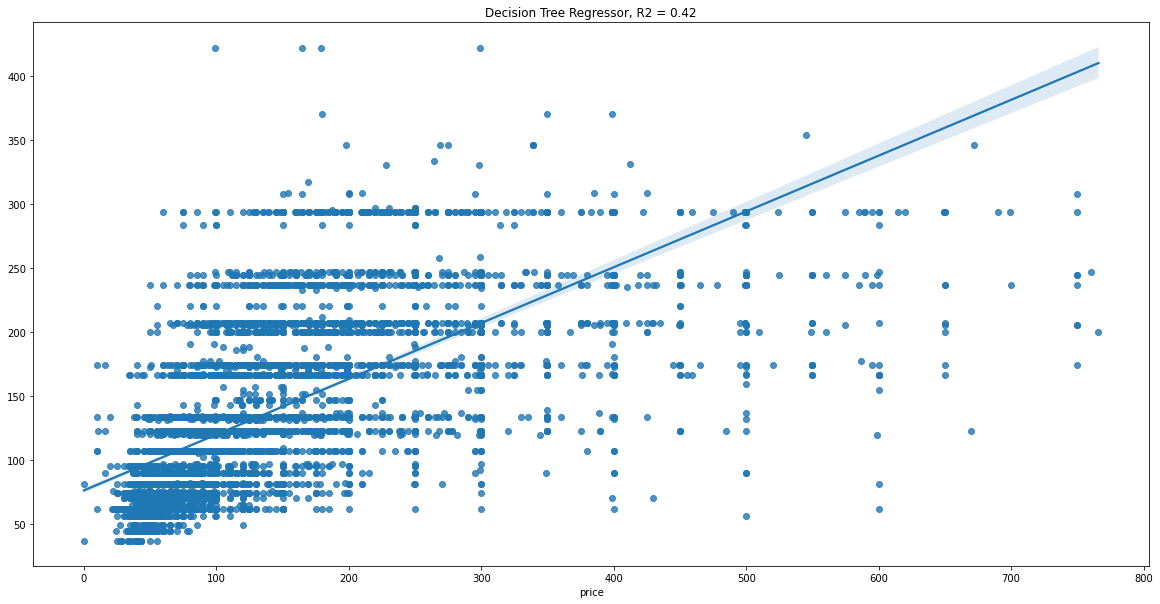

-------------------------------------------------
Decision Tree Regressor: finished


In [8]:
df_DT = DT_tuning(X_train, X_test, y_train, y_test)

In [32]:
df_DT

,Model,Cross-Val Score,MSE,RMSE,MAE,R2
0,Decision Tree Regressor,-2095.154755,2266.687247,47.609739,34.952284,0.502465


In [9]:
def RF_tuning():
    # Grid Search
    # choix des hyperparamètres à tester pour le modèle RandomForestRegressor    
    param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_samples' : [0.5, 0.75, 1]
    }

    # cross validation avec 5 folds et mélange des données à chaque itération
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # création du modèle
    rf_model = RandomForestRegressor(random_state=42)


    start = time.time()

    # initialisation de la Grid Search avec les hyperparamètres à tester, le modèle et le nombre de folds
    grid_search = RandomizedSearchCV(rf_model, param_grid, cv=cv, n_jobs=-1, verbose=1, scoring= 'neg_mean_squared_error', n_iter=100)

    grid_search.fit(X_train, y_train)

    print(f'Best params: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}')

    end = time.time()

    print(f'Grid Search took {end - start} seconds')

    print('Grid Search fini !')

    print('---------')

    rf = RandomForestRegressor(random_state=42,**grid_search.best_params_)
    
    model_test = rf.fit(X_train, y_train)
        
    y_pred = model_test.predict(X_test)

    # compute mse_dt
    mse_rf = mean_squared_error(y_test, y_pred)

    # compute rmse_dt
    rmse_rf = np.sqrt(mse_rf)

    # compute mae_dt

    mae_rf = mean_absolute_error(y_test, y_pred)

    # compute r2_dt

    r2_rf = r2_score(y_test, y_pred)

    df_results = pd.DataFrame({'Model': ['Random Forest Regressor'], 'Cross-Val Score': [grid_search.best_score_], 'MSE': [mse_rf], 'RMSE': [rmse_rf], 'MAE': [mae_rf], 'R2': [r2_rf]})

    # show the results

    #use pprint to print the results in a nice format

    pp = pprint.PrettyPrinter()  # set the indentation level to 4
    pp.pprint(df_results)

    print('-------------------------------------------------')

    #plot feature importance 

    feature_importance = pd.DataFrame({'feature': colname, 'importance': model_test.feature_importances_})
    feature_importance.sort_values('importance', ascending=False, inplace=True)
    feature_importance.reset_index(drop=True, inplace=True)

    # plot
    plt.figure(figsize=(10, 10))
    sns.barplot(x='importance', y='feature', data=feature_importance.iloc[:20])
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    print('-------------------------------------------------')

    #plot regression

    plt.figure(figsize=(10,10))
    sns.regplot(x=y_test, y=y_pred)
    plt.title(f'Random Forest Regressor, R2 = {np.round(r2_rf,2)}')

    plt.show()

    print('-------------------------------------------------')

    print('Random Forest Regressor: finished')

    return df_results

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params: {'n_estimators': 200, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_samples': 0.5, 'max_depth': 9}
Best score: -5515.701757409362
Grid Search took 78.15329813957214 seconds
Grid Search fini !
---------
                     Model  Cross-Val Score          MSE       RMSE  \
0  Random Forest Regressor     -5515.701757  5050.784796  71.068874   

         MAE        R2  
0  44.167434  0.457483  
-------------------------------------------------


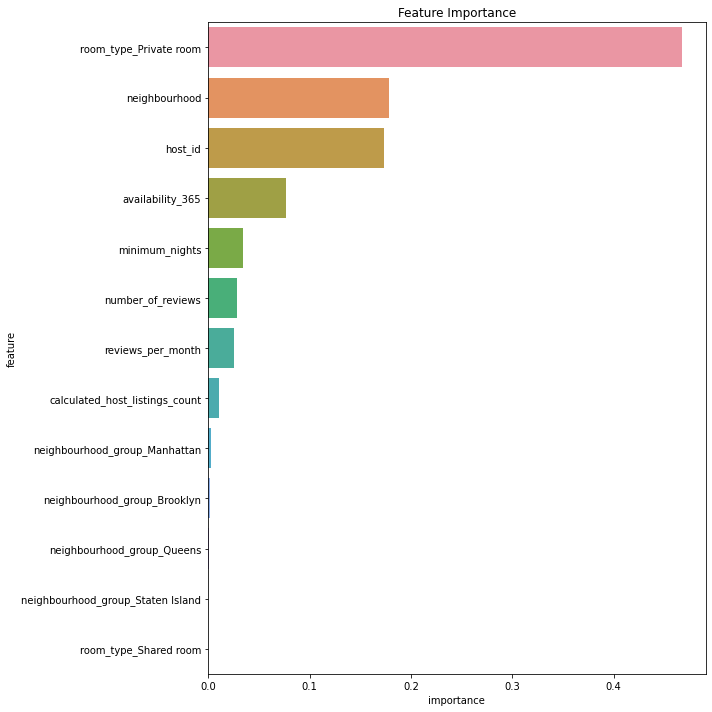

-------------------------------------------------


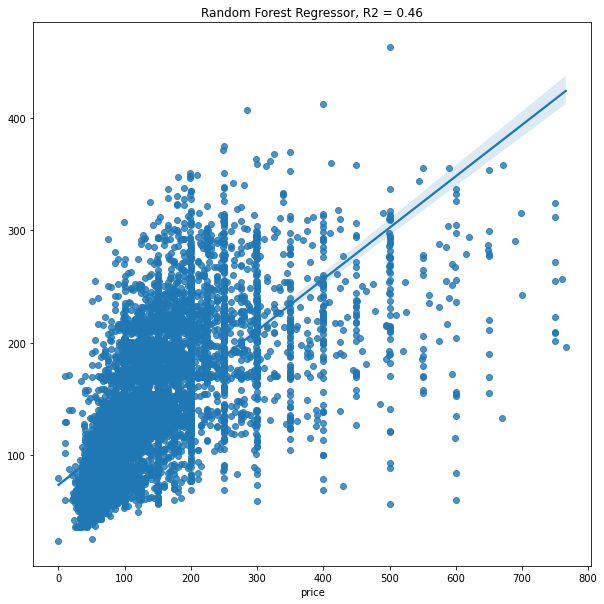

-------------------------------------------------
Random Forest Regressor: finished


In [10]:
df_RF = RF_tuning()

In [35]:
df_RF

,Model,Cross-Val Score,MSE,RMSE,MAE,R2
0,Random Forest Regressor,-1995.790949,2196.192271,46.863549,34.230313,0.517938


In [30]:
def XGBoost_tuning():
    param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1]
    }

    # cross validation avec 5 folds et mélange des données à chaque itération
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # création du modèle
    xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=-1, tree_method='gpu_hist', random_state=42)
    
    start = time.time() # début du chronomètre

    # initialisation de la Grid Search avec les hyperparamètres à tester, le modèle et le nombre de folds
    grid_search = RandomizedSearchCV(xgb_model, param_grid, cv=cv, n_jobs=-1, verbose=1, scoring= 'neg_mean_squared_error', n_iter=100)
    grid_search.fit(X_train, y_train)

    #print the best parameters
    print(f'Best params: {grid_search.best_params_}')

    #print the best score
    print(f'Best score: {grid_search.best_score_}')

    end = time.time() # fin du chronomètre

    print(f'Grid Search took {end - start} seconds')

    print('Grid Search fini !')

    print('---------')

    xgtrain = xgb.DMatrix(X_train, label=y_train)
    xgtest = xgb.DMatrix(X_test, label=y_test)

    gbr =  xgb.XGBRegressor( objective ='reg:squarederror', n_jobs=-1, tree_method='gpu_hist', random_state=42, **grid_search.best_params_)

    model_test = xgb.train(gbr.get_xgb_params(), xgtrain, num_boost_round=1000, early_stopping_rounds=10, evals=[(xgtest, 'test')], verbose_eval=False)

    y_pred = model_test.predict(xgtest)

    # compute mse_dt
    mse_xgb = mean_squared_error(y_test, y_pred)

    # compute rmse_dt
    rmse_xgb = np.sqrt(mse_xgb)

    # compute mae_dt

    mae_xgb = mean_absolute_error(y_test, y_pred)

    # compute r2_dt

    r2_xgb = r2_score(y_test, y_pred)

    df_results = pd.DataFrame({'Model': ['XGBoost'], 'Cross-Val Score': [grid_search.best_score_], 'MSE': [mse_xgb], 'RMSE': [rmse_xgb], 'MAE': [mae_xgb], 'R2': [r2_xgb]})

    # show the results
    #use pprint to print the results in a nice format

    pp = pprint.PrettyPrinter()  # set the indentation level to 4
    pp.pprint(df_results)

    print('-------------------------------------------------')

    #plot feature importance
    # plt.figure(figsize=(10,10))

    #xgb.plot_importance(model_test, max_num_features=10, importance_type='gain')    
    # plt.show()

    #plot feature importance 

    # get feature importance
    importance = model_test.get_score(importance_type='gain')

    # create a list of tuples with feature name and importance score
    feature_importance = [(colname[int(k[1:])], v) for k, v in importance.items()]


    # create dataframe from the list of tuples
    feature_importance_df = pd.DataFrame(feature_importance, columns=['feature', 'importance'])
    feature_importance_df.sort_values('importance', ascending=False, inplace=True)

    # plot feature importance
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(x='importance', y='feature', data=feature_importance_df.iloc[:10])
    ax.set_yticks(range(len(feature_importance_df)))
    ax.set_yticklabels(feature_importance_df['feature'])
    plt.show()

    print('-------------------------------------------------')

    #plot regression

    plt.figure(figsize=(10,10))
    sns.regplot(x=y_test, y=y_pred)
    plt.title(f'XGBoost, R2 = {np.round(r2_xgb,2)}')

    plt.show()

    print('-------------------------------------------------')

    print('XGBoost: finished')

    return df_results   
    

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params: {'subsample': 0.5, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 1}
Best score: -6574.366792777242
Grid Search took 412.7246334552765 seconds
Grid Search fini !
---------
     Model  Cross-Val Score          MSE       RMSE       MAE        R2
0  XGBoost     -6574.366793  5516.639352  74.274083  44.59278  0.456757
-------------------------------------------------


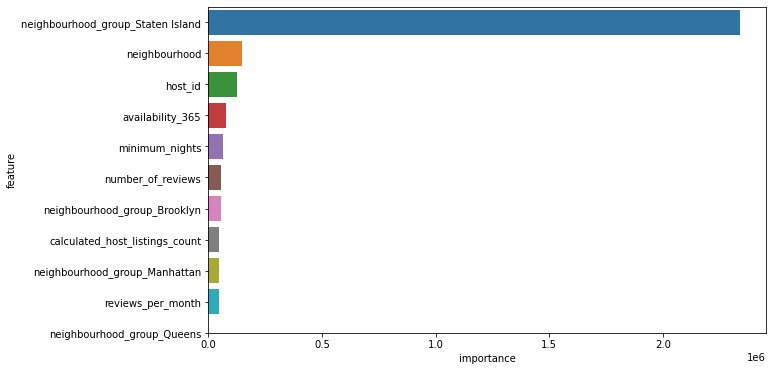

-------------------------------------------------


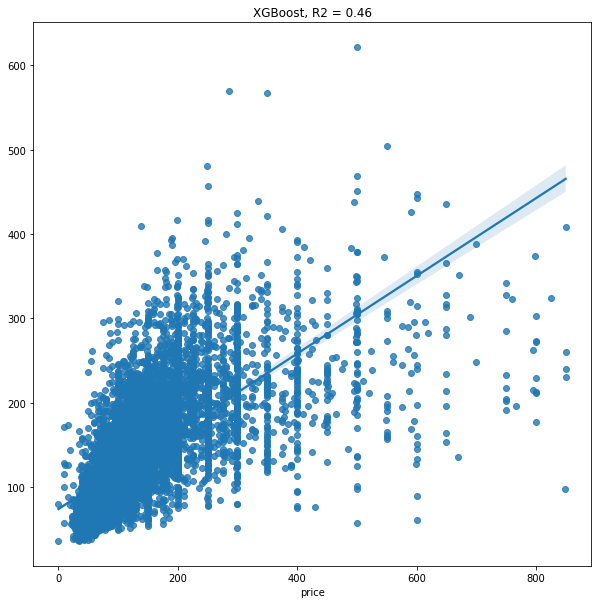

-------------------------------------------------
XGBoost: finished


In [31]:
df_XGB = XGBoost_tuning()

In [32]:
df_XGB

,Model,Cross-Val Score,MSE,RMSE,MAE,R2
0,XGBoost,-6574.366793,5516.639352,74.274083,44.59278,0.456757


In [38]:
df_XGB

,Model,Cross-Val Score,MSE,RMSE,MAE,R2
0,XGBoost,-1963.865893,2165.161521,46.531296,33.947714,0.52475


In [39]:
#join the results of the three tuned models in a single dataframe

df_results = pd.concat([df_DT, df_RF, df_XGB], ignore_index=True)

#change the name of the models to add "_tuned" at the end

df_results['Model'] = df_results['Model'].apply(lambda x: x + '_tuned')

# join the results of the three tuned models with the results of the untuned models

df_final_results = pd.concat([df_results, df_models], ignore_index=True)

df_final_results = df_final_results.sort_values(by=['R2', 'RMSE'], ascending=[False, True])

df_final_results

,Model,Cross-Val Score,MSE,RMSE,MAE,R2
2,XGBoost_tuned,-1963.865893,2165.161521,46.531296,33.947714,0.524750
3,CatBoostRegressor,0.554403,2176.474817,46.652704,34.015688,0.522266
4,LightGBMRegressor,0.551189,2183.290098,46.725690,34.115956,0.520770
5,GradientBoostingRegressor,0.550497,2195.147285,46.852399,34.308613,0.518168
1,Random Forest Regressor_tuned,-1995.790949,2196.192271,46.863549,34.230313,0.517938
6,XGBoostRegressor,0.529966,2217.687625,47.092331,34.428160,0.513220
0,Decision Tree Regressor_tuned,-2095.154755,2266.687247,47.609739,34.952284,0.502465
7,RandomForestRegressor,0.491737,2408.008354,49.071462,35.830612,0.471445
8,Bagging Regressor,0.456306,2557.480510,50.571539,36.925628,0.438636
9,ExtraTreesRegressor,0.445469,2571.690390,50.711837,36.904386,0.435517
